In [1]:
%%capture
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sqlite3
import plotting_utils
import data_io_utils
import agn_utils
pd.options.display.max_columns = None
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Validating the DRW Parameter Distributions of the DC2 AGN

__Author:__ Ji Won Park (@jiwoncpark) <br>
__Created:__ 11/18/2019 <br>
__Last run:__ 1/02/2020 <br>
__Goals:__
- Ensure that the parameter distributions of the DC2 DDF AGN agree with those found in SDSS S82 (see `Reproduce_S82_DRW.ipynb`)
- Brainstorm further tests for possible discrepancies

__Before running:__
1. Set up `sims_GCRCatSimInterface` by running
```bash
# Set up desc-stack
python /global/common/software/lsst/common/miniconda/start-kernel-cli.py desc-stack
# Set up sims_GCRCatSimInterface
git clone https://github.com/LSSTDESC/sims_GCRCatSimInterface.git <desired location>
cd <desired location>/sims_GCRCatSimInterface
eups declare -r .
```

2. Create a jupyter kernel with the setup. Create a text file with the below content, titled `<my_kernel>.sh` where `<my_kernel>` is the desired kernel name.
```bash
#!/usr/bin/env bash
source /global/common/software/lsst/cori-haswell-gcc/stack/setup_sims_w_2019_23.sh
setup lsst_sims
setup -r <desired location> -j
exec python -m ipykernel $@
```

3. Switch to this kernel in the Jupyter interface.

## Accessing the DC2 v1.1.4 AGN database

1. Let's join the DDF AGN database and `cosmoDC2`.

In [ ]:
# This line, which saves the relevant files to my scratch space, has been run. Start with the next cell.
data_io_utils.join_agn_with_cosmodc2_in_chunks(agn_db_path='/global/cscratch1/sd/jchiang8/desc/Run2.2i/agn_catalog/2019-11-21/cosmoDC2_agn.db', 
                                 save_dir='/global/cscratch1/sd/jwp/agn_validation/errorfit_oversampled', 
                                 dictcol_name='varParamStr')

125
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [3]:
agn_db_path = '/global/cscratch1/sd/jwp/agn_validation/errorfit_oversampled/joined_0.csv'
agn_df = pd.read_csv(agn_db_path, index_col=False)

for prejoined_idx in range(1, 25):
    new_agn_db_path = '/global/cscratch1/sd/jwp/agn_validation/errorfit_oversampled/joined_{:d}.csv'.format(prejoined_idx)
    agn_df = pd.concat([agn_df, pd.read_csv(new_agn_db_path, index_col=False)], axis=0, sort=False, ignore_index=True)
print(agn_df.shape)

(6250000, 21)


Here are the available columns. 

In [4]:
print(agn_df.columns)

Index(['Unnamed: 0', 'blackHoleMass', 'galaxy_id', 'blackHoleAccretionRate',
       'redshift', 'blackHoleEddingtonRatio', 'htmid_8', 'magNorm', 'seed',
       'agn_sf_u', 'agn_sf_g', 'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y',
       'agn_tau_u', 'agn_tau_g', 'agn_tau_r', 'agn_tau_i', 'agn_tau_z',
       'agn_tau_y'],
      dtype='object')


2. This is missing the absolute i-band magnitude, so we join with another db that has it.

In [5]:
agn_with_Mi_path = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_param_db_with_Mi.db'
conn = sqlite3.connect(agn_with_Mi_path)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())
agn_Mi_df = pd.read_sql_query("SELECT galaxy_id, M_i FROM agn_params", conn)

[('agn_params',)]


In [6]:
# ~ 1 min
agn_df = agn_df.merge(agn_Mi_df, how='inner', on='galaxy_id')
print(agn_df.shape)
print(agn_df.columns)

(6250000, 22)
Index(['Unnamed: 0', 'blackHoleMass', 'galaxy_id', 'blackHoleAccretionRate',
       'redshift', 'blackHoleEddingtonRatio', 'htmid_8', 'magNorm', 'seed',
       'agn_sf_u', 'agn_sf_g', 'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y',
       'agn_tau_u', 'agn_tau_g', 'agn_tau_r', 'agn_tau_i', 'agn_tau_z',
       'agn_tau_y', 'M_i'],
      dtype='object')


3. Yet another table made by Scott (@danielsf) has the LSST `ugrizy` magnitudes of the AGN, so we'll join with that table too.

In [7]:
# < 1 min
agn_model_path = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_model_191006.h5'
agn_model_h5 = h5py.File(agn_model_path, 'r')
print(list(agn_model_h5.keys()))
agn_model_dict = {}
for key in ['galaxy_id', 'u', 'g', 'r', 'i', 'z', 'y', 'duty_cycle']: #agn_model_h5.keys():
    agn_model_dict[key] = agn_model_h5[key]
agn_model_df = pd.DataFrame.from_dict(agn_model_dict, orient='columns')

['dec', 'duty_cycle', 'g', 'galaxy_id', 'i', 'magNorm', 'r', 'ra', 'seed', 'sfg', 'sfi', 'sfr', 'sfu', 'sfy', 'sfz', 'tau', 'u', 'y', 'z']


In [8]:
# < 1 min
agn_df = agn_df.merge(agn_model_df, how='inner', on='galaxy_id')
print(agn_df.shape)
print(agn_df.columns)

(6250000, 29)
Index(['Unnamed: 0', 'blackHoleMass', 'galaxy_id', 'blackHoleAccretionRate',
       'redshift', 'blackHoleEddingtonRatio', 'htmid_8', 'magNorm', 'seed',
       'agn_sf_u', 'agn_sf_g', 'agn_sf_r', 'agn_sf_i', 'agn_sf_z', 'agn_sf_y',
       'agn_tau_u', 'agn_tau_g', 'agn_tau_r', 'agn_tau_i', 'agn_tau_z',
       'agn_tau_y', 'M_i', 'u', 'g', 'r', 'i', 'z', 'y', 'duty_cycle'],
      dtype='object')


Andrew (@aphearin) has implemented the duty cycle model in which the quasar host probability is zero for galaxies redder than the green valley and depends on the distance from the green valley for galaxies bluer than the green valley. We want to only include galaxies with `duty_cycle=True`.

In [9]:
agn_df[agn_df['duty_cycle']==True].shape

(849696, 29)

4. Separate out the bandpass observations, so that each AGN is "oversampled" by six. The plotting code requires this format, as it was developed on the SDSS data, in which not all AGN were observed in all five SDSS filters.

In [60]:
agn_df_dict = {}
common_cols = [
       'blackHoleMass', 'blackHoleAccretionRate',
       'galaxy_id', 'blackHoleEddingtonRatio',
       'redshift', 'magNorm', 'seed', 'duty_cycle',
       'M_i', 'u', 'g', 'r', 'i', 'z', 'y']

for bp in 'ugriz':
    agn_df_bp = agn_df[common_cols].copy()
    agn_df_bp['sf_inf'] = agn_df['agn_sf_{:s}'.format(bp)].values
    agn_df_bp['tau'] = agn_df['agn_tau_{:s}'.format(bp)].values
    agn_df_bp['bandpass'] = bp
    agn_df_dict[bp] = agn_df_bp
    del agn_df_bp # not necessary
    
merged = pd.concat(agn_df_dict, axis=0)

In [61]:
merged.shape

(31250000, 18)

## Selection

In [62]:
oversample_factor = 6250000/73000
area = 1.25*oversample_factor # sq deg

In [63]:
merged['redshift'].max(), merged['redshift'].min()

(3.1669341263335604, 0.014810955338234287)

In [64]:
selected = merged.loc[merged['i'] < 20.5].copy()
print(selected.shape)

(44070, 18)


In [65]:
selected[selected['duty_cycle'] == True].shape

(8635, 18)

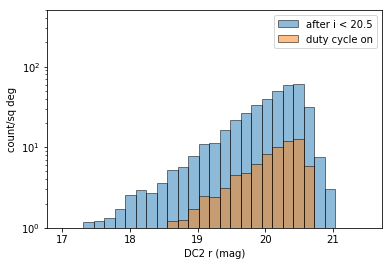

In [66]:
bins=np.linspace(17, 21.5, 30)
#_ = plt.hist(merged['r'].values, weights=np.ones_like(merged['r'].values)/area, bins=bins, edgecolor='k', label='all AGN', alpha=0.5)
#_ = plt.hist(merged.loc[merged['duty_cycle']==True]['r'].values, weights=np.ones_like(merged.loc[merged['duty_cycle']==True]['r'].values)/area, bins=bins, edgecolor='k', label='duty cycle on', alpha=0.5)
_ = plt.hist(selected['r'].values, weights=np.ones_like(selected['r'].values)/area, bins=bins, edgecolor='k', label='after i < 20.5', alpha=0.5)
_ = plt.hist(selected.loc[selected['duty_cycle']==True]['r'].values, weights=np.ones_like(selected.loc[selected['duty_cycle']==True]['r'].values)/area, bins=bins, edgecolor='k', label='duty cycle on', alpha=0.5)

plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("DC2 r (mag)")
plt.legend()

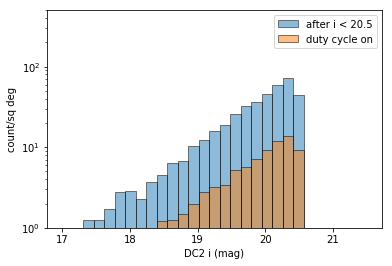

In [67]:
bins=np.linspace(17, 21.5, 30)
#_ = plt.hist(merged['i'].values, weights=np.ones_like(merged['r'].values)/area, bins=bins, edgecolor='k', label='all AGN', alpha=0.5)
#_ = plt.hist(merged.loc[merged['duty_cycle']==True]['i'].values, weights=np.ones_like(merged.loc[merged['duty_cycle']==True]['r'].values)/area, bins=bins, edgecolor='k', label='duty cycle on', alpha=0.5)
_ = plt.hist(selected['i'].values, weights=np.ones_like(selected['r'].values)/area, bins=bins, edgecolor='k', label='after i < 20.5', alpha=0.5)
_ = plt.hist(selected.loc[selected['duty_cycle']==True]['i'].values, weights=np.ones_like(selected.loc[selected['duty_cycle']==True]['r'].values)/area, bins=bins, edgecolor='k', label='duty cycle on', alpha=0.5)

plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("DC2 i (mag)")
plt.legend()

Text(0.5, 0, 'DC2 i (mag)')

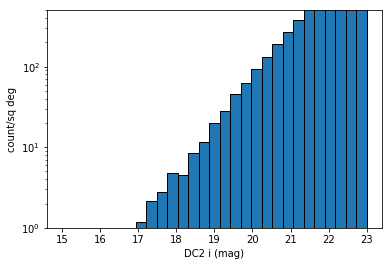

In [68]:
_ = plt.hist(merged['i'].values, weights=np.ones_like(merged['r'].values)/area, bins=np.linspace(15, 23, 30), edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("DC2 i (mag)")

Text(0.5, 0, 'DC2 i (mag)')

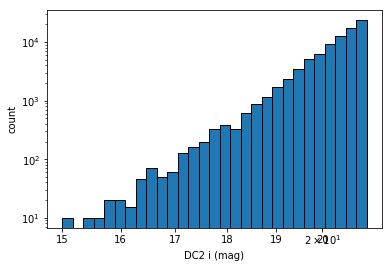

In [69]:
_ = plt.hist(merged['i'].values, bins=10**np.linspace(np.log10(15), np.log10(21), 30), edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.gca().set_xscale('log')
plt.gca().set_xticks(np.arange(15, 21, 1))
plt.gca().set_xticklabels(np.arange(15, 21, 1))
plt.ylabel("count")
plt.xlabel("DC2 i (mag)")

Text(0.5, 0, 'DC2 u (mag)')

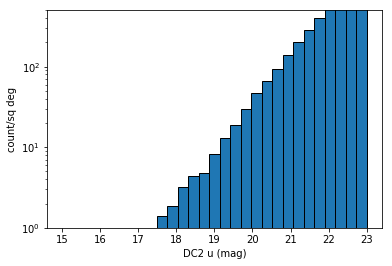

In [70]:
_ = plt.hist(merged['u'].values, weights=np.ones_like(merged['r'].values)/area, bins=np.linspace(15, 23, 30), edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("DC2 u (mag)")

M_i brightest: -31.164917


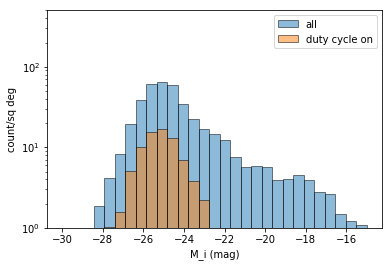

In [71]:
_ = plt.hist(selected['M_i'].values, weights=np.ones_like(selected['M_i'].values)/area, 
             bins=np.linspace(-30, -15, 30), edgecolor='k', alpha=0.5, label='all')
_ = plt.hist(selected.loc[selected['duty_cycle']==True, 'M_i'].values, 
             weights=np.ones_like(selected.loc[selected['duty_cycle']==True, 'M_i'].values)/area,
             bins=np.linspace(-30, -15, 30), edgecolor='k', alpha=0.5, label='duty cycle on')

print("M_i brightest: {:f}".format(merged['M_i'].values.min()))
plt.yscale('log', nonposy='clip')
plt.ylim([1, 500])
plt.ylabel("count/sq deg")
plt.xlabel("M_i (mag)")
plt.legend()

Text(0.5, 0, 'DC2 redshift')

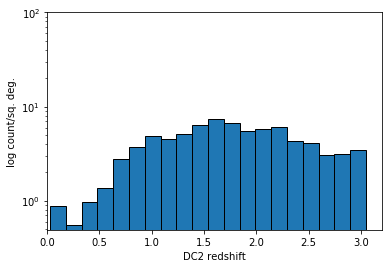

In [72]:
plt.hist(selected.loc[selected['duty_cycle']==True, 'redshift'], 
         weights=np.ones_like(selected.loc[selected['duty_cycle']==True, 'redshift'].values)/area,
         bins=20,
         edgecolor='k')
plt.yscale('log', nonposy='clip')
plt.ylim([0, 100])
plt.xlim([0, 3.2])
plt.ylabel('log count/sq. deg.')
plt.xlabel('DC2 redshift')

## Distribution rest-frame $\tau$

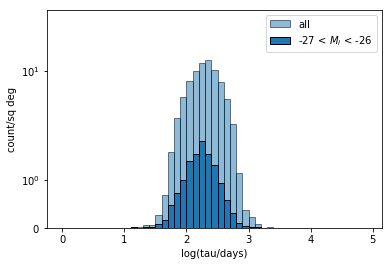

In [137]:
selected['log_rf_tau'] = np.log10(selected['tau'].values)
plotting_utils.plot_fig3_topleft(selected, area)

## Distribution of $SF_{\infty}$

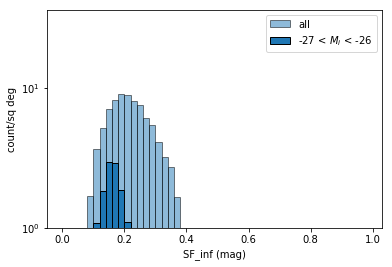

In [138]:
selected['log_sf_inf'] = np.log10(selected['sf_inf'].values)
plotting_utils.plot_fig3_topright(selected, area)

## $\log \tau$ vs. $\log SF_\infty$

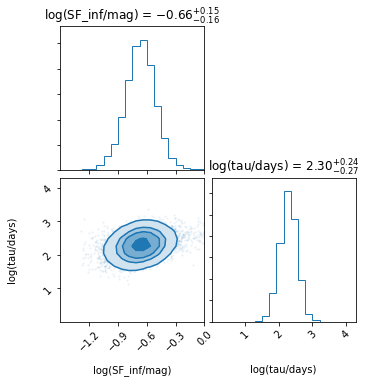

In [139]:
plotting_utils.plot_fig3_bottom(selected, None)

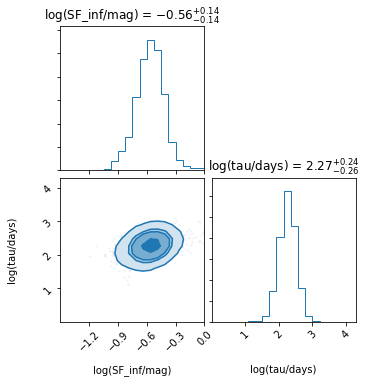

In [140]:
plotting_utils.plot_fig3_bottom(selected, bandpass='u')

In [141]:
selected = selected[selected['duty_cycle']==True].copy()

## Dependence on rest-frame wavelength

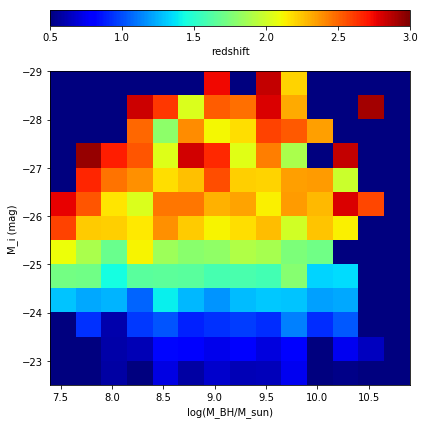

In [142]:
# Fig 12 top left
selected['log_BH_mass'] = np.log10(selected['blackHoleMass'].values)
plotting_utils.plot_2d_hist_stats(selected, 
                   colnames_2d=['log_BH_mass', 'M_i'],
                   bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29, -22.0, 0.5)],
                   invert_y_axis=True,
                   colname_color='redshift',
                   ticks_color=np.arange(0.5, 3.2, 0.5),
                   invert_color=False,
                   x_label='log(M_BH/M_sun)',
                   y_label='M_i (mag)',
                   color_label='redshift',
                   cmap_name='jet')

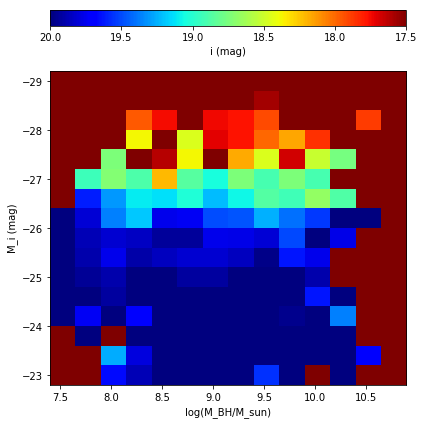

In [143]:
# Fig 12 top right
plotting_utils.plot_2d_hist_stats(selected, 
                           colnames_2d=['log_BH_mass', 'M_i'],
                           bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                           invert_y_axis=True,
                           colname_color='i',
                           ticks_color=np.arange(17.5, 20.5, 0.5),
                           invert_color=True,
                           x_label='log(M_BH/M_sun)',
                           y_label='M_i (mag)',
                           color_label='i (mag)',
                           cmap_name='jet_r')

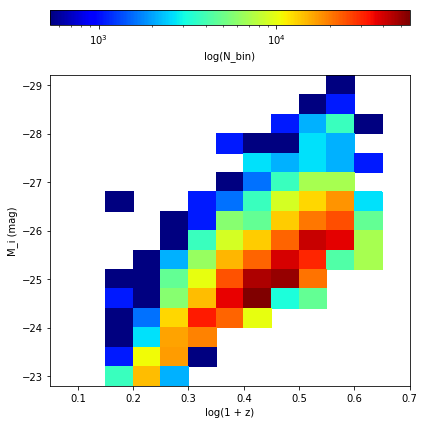

In [144]:
# Fig 12 bottom left
x = np.log10(selected['redshift'].values + 1.0)
y = selected['M_i'].values
x_bins = np.arange(0.05, 0.75, 0.05)
y_bins = np.arange(-29.2, -22.5, 0.4)

plotting_utils.plot_2d_hist(x, y, x_bins, y_bins,
                   invert_y_axis=True,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(1 + z)',
                   y_label='M_i (mag)',
                   color_label='log(N_bin)',
                   cmap_name='jet',
                           weight=1.0/area)

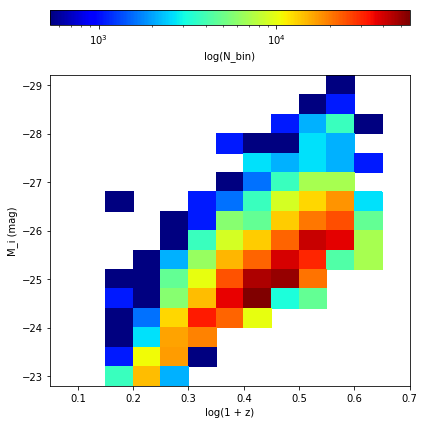

In [145]:
# Fig 12 bottom left
x = np.log10(selected['redshift'].values + 1.0)
y = selected['M_i'].values
x_bins = np.arange(0.05, 0.75, 0.05)
y_bins = np.arange(-29.2, -22.5, 0.4)

plotting_utils.plot_2d_hist(x, y, x_bins, y_bins,
                   invert_y_axis=True,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(1 + z)',
                   y_label='M_i (mag)',
                   color_label='log(N_bin)',
                   cmap_name='jet',
                           weight=1.0/area)

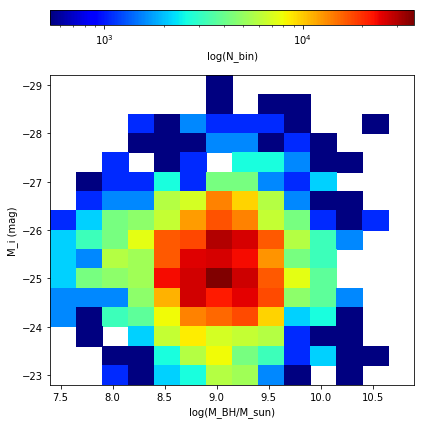

In [149]:
# Fig 12 bottom right
x = selected['log_BH_mass'].values
y = selected['M_i'].values
x_bins = np.arange(7.4, 11.0, 0.25)
y_bins = np.arange(-29.2, -22.5, 0.4)

plotting_utils.plot_2d_hist(x, y, x_bins, y_bins,
                   invert_y_axis=True,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(M_BH/M_sun)',
                   y_label='M_i (mag)',
                   color_label='log(N_bin)',
                   cmap_name='jet',
                           weight=1.0/area)

(1727,)
(1727,)
(1727,)
(1727,)
(1727,)


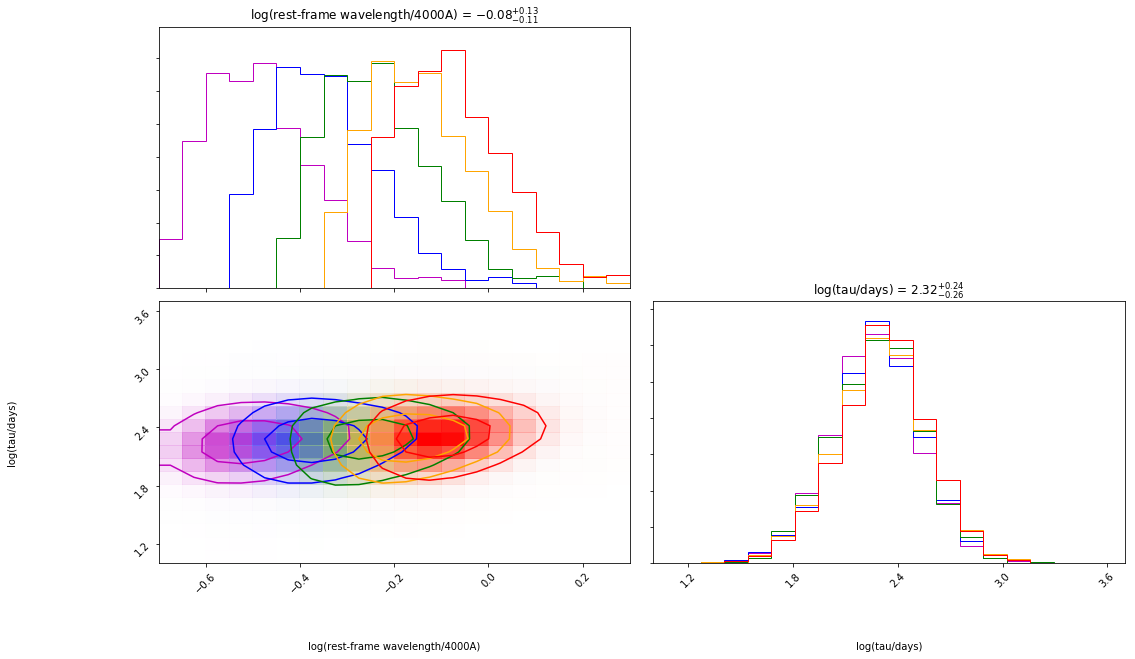

In [150]:
# Fig 13 top
# Normalizing wavelength
wavelength_norm = 4000.0 # in angstroms
# Central wavelength (value) for each SDSS bandpass (key) used to estimate the rest-frame wavelength
wavelength_center = {'u': 3520.0, 'g': 4800.0, 'r': 6250.0, 'i': 7690.0, 'z': 9110.0} # iM_i_kcorr_xn angstroms
selected['rf_wavelength'] = 0.0
selected['log_rf_wavelength'] = 0.0
for bp in 'ugriz':
    # z correction
    z_corr = 1.0/(1.0 +  selected.loc[selected['bandpass']==bp]['redshift'].values)
    print(selected.loc[selected['bandpass']==bp]['redshift'].values.shape)
    #z_corr = 0.5
    # normalized rest-frame wavelength
    selected.loc[selected['bandpass']==bp, 'rf_wavelength'] = wavelength_center[bp]*z_corr/wavelength_norm 
    selected.loc[selected['bandpass']==bp, 'log_rf_wavelength'] = np.log10(selected.loc[selected['bandpass']==bp]['rf_wavelength'].values)
plotting_utils.plot_fig13(selected, 'log_rf_tau', [1, 3.7], 'log(tau/days)')

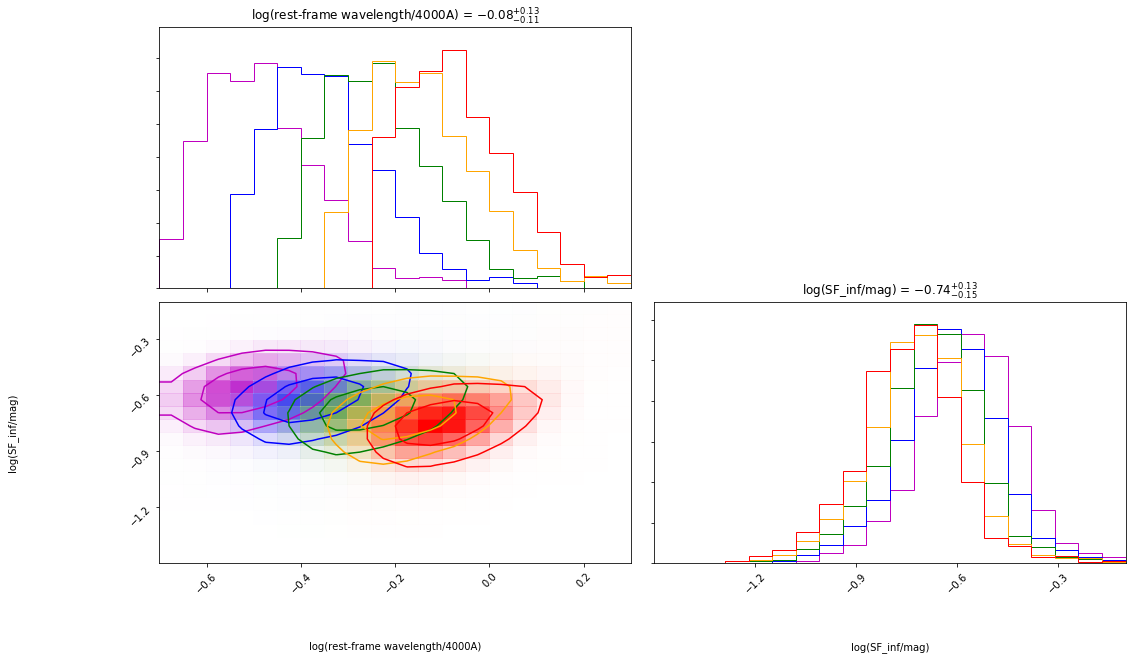

In [148]:
# Fig 13 bottom
plotting_utils.plot_fig13(selected, 'log_sf_inf', [-1.5, -0.1], 'log(SF_inf/mag)')

## Dependence on luminosity, redshift, and black hole mass

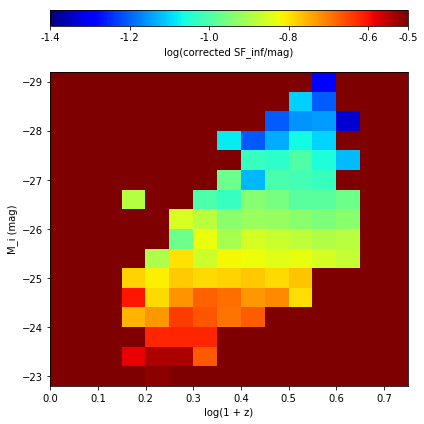

In [151]:
# Fig 14 top left
B_sf_inf = -0.479
selected['log_z_corr_inv'] = np.log10(1.0 + selected['redshift'].values)
selected['log_sf_inf_corrected'] = selected['log_sf_inf'].values - B_sf_inf*selected['log_rf_wavelength'].values

plotting_utils.plot_2d_hist_stats(selected,
                         colnames_2d=['log_z_corr_inv', 'M_i'],
                         bins_2d=[np.arange(0.0, 0.8, 0.05), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_sf_inf_corrected',
                         ticks_color=[-1.4, -1.2, -1.0, -0.8, -0.6, -0.5],
                         invert_color=False,
                         x_label='log(1 + z)',
                         y_label='M_i (mag)',
                         color_label='log(corrected SF_inf/mag)',
                         cmap_name='jet')

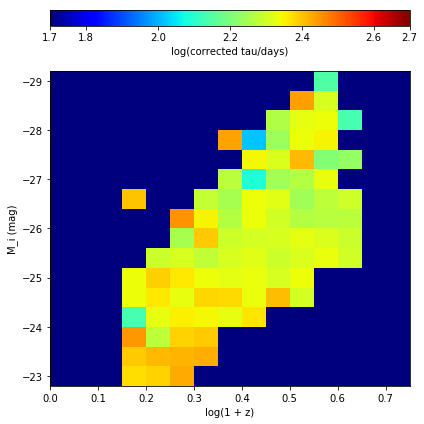

In [152]:
# Fig 14 top right
B_tau = 0.17
selected['log_rf_tau_corrected'] = selected['log_rf_tau'].values - B_tau*selected['log_rf_wavelength'].values

plotting_utils.plot_2d_hist_stats(selected,
                         colnames_2d=['log_z_corr_inv', 'M_i'],
                         bins_2d=[np.arange(0.0, 0.8, 0.05), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_rf_tau_corrected',
                         ticks_color=[1.7, 1.8, 2.0, 2.2, 2.4, 2.6, 2.7],
                         invert_color=False,
                         x_label='log(1 + z)',
                         y_label='M_i (mag)',
                         color_label='log(corrected tau/days)',
                         cmap_name='jet')

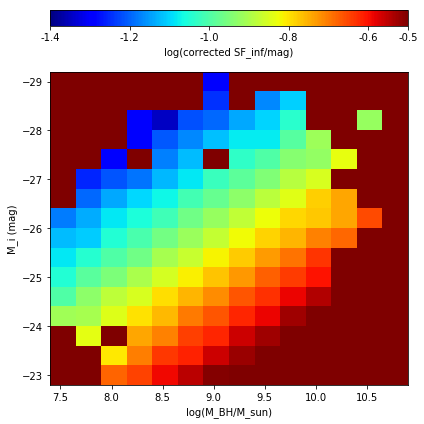

In [153]:
# Fig 14 bottom left
plotting_utils.plot_2d_hist_stats(selected,
                         colnames_2d=['log_BH_mass', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_sf_inf_corrected',
                         ticks_color=[-1.4, -1.2, -1.0, -0.8, -0.6, -0.5],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(corrected SF_inf/mag)',
                         cmap_name='jet')

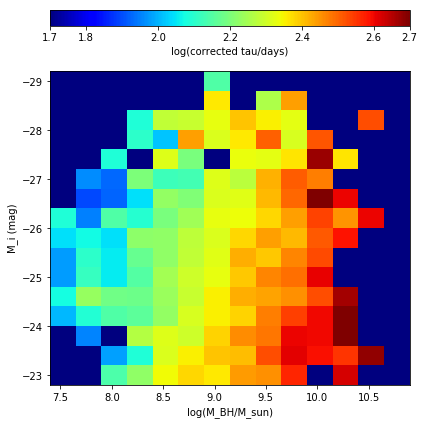

In [154]:
# Fig 14 bottom right
plotting_utils.plot_2d_hist_stats(selected,
                         colnames_2d=['log_BH_mass', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_rf_tau_corrected',
                         ticks_color=[1.7, 1.8, 2.0, 2.2, 2.4, 2.6, 2.7],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(corrected tau/days)',
                         cmap_name='jet')

## Eddington ratio partly drives variability

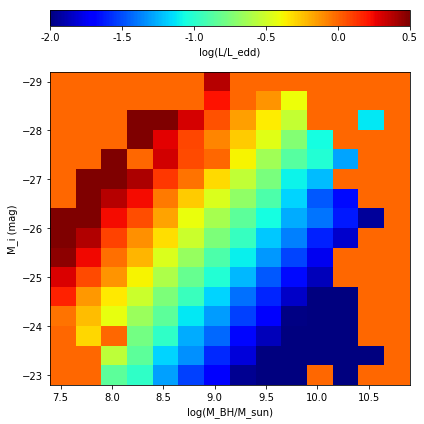

In [155]:
# Fig 15 left
#log_L_edd = np.log10(1.5) + 38.0 + lam_fit['mass_BH'].values # approximation used by MacLeod et al 2010, in erg/s
#lam_fit['log_edd_ratio'] = lam_fit['Lbol'].values - log_L_edd
selected['log_edd_ratio'] = np.log10(selected['blackHoleEddingtonRatio'].values)
plotting_utils.plot_2d_hist_stats(selected,
                         colnames_2d=['log_BH_mass', 'M_i'],
                         bins_2d=[np.arange(7.4, 11.0, 0.25), np.arange(-29.2, -22.5, 0.4)],
                         invert_y_axis=True,
                         colname_color='log_edd_ratio',
                         ticks_color=[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5],
                         invert_color=False,
                         x_label='log(M_BH/M_sun)',
                         y_label='M_i (mag)',
                         color_label='log(L/L_edd)',
                         cmap_name='jet')

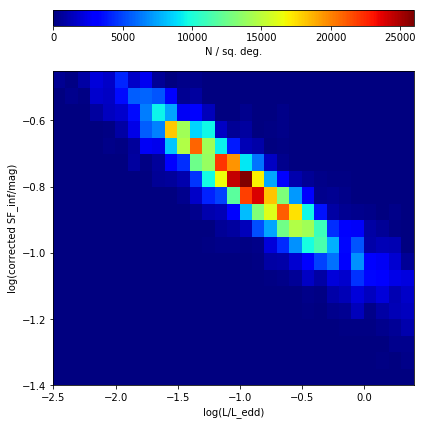

In [157]:
# Fig 15 right

plotting_utils.plot_2d_hist(selected['log_edd_ratio'].values,
                   selected['log_sf_inf_corrected'].values,
                   np.arange(-2.5, 0.5, 0.1),
                   np.arange(-1.4, -0.4, 0.05),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=False,
                   x_label='log(L/L_edd)', 
                   y_label='log(corrected SF_inf/mag)',
                   color_label='N / sq. deg.',
                   cmap_name='jet',
                          weight=1.0/area)

In [158]:
merged.columns

Index(['blackHoleMass', 'blackHoleAccretionRate', 'galaxy_id',
       'blackHoleEddingtonRatio', 'redshift', 'magNorm', 'seed', 'duty_cycle',
       'M_i', 'u', 'g', 'r', 'i', 'z', 'y', 'sf_inf', 'tau', 'bandpass'],
      dtype='object')

## Additional plots for comparison

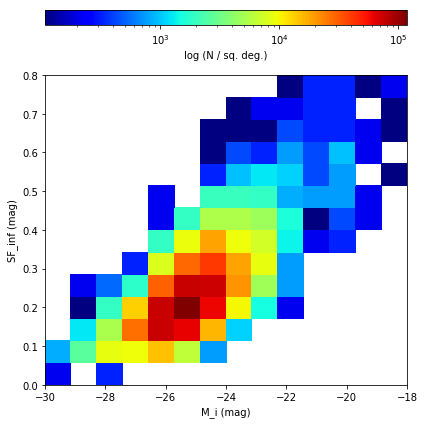

In [159]:
plotting_utils.plot_2d_hist(selected['M_i'].values,
                   10**selected['log_sf_inf'].values,
                   np.linspace(-30, -18, 15),
                   np.linspace(0.0, 0.8, 15),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='M_i (mag)', 
                   y_label='SF_inf (mag)',
                   color_label='log (N / sq. deg.)',
                   cmap_name='jet',
                           weight=1.0/area)

In [160]:
selected.shape

(8635, 31)

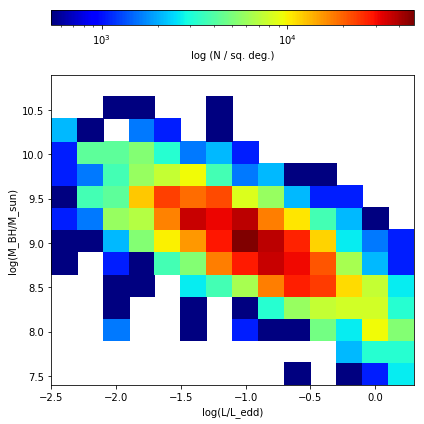

In [161]:
plotting_utils.plot_2d_hist(selected['log_edd_ratio'].values,
                   selected['log_BH_mass'].values,
                   np.arange(-2.5, 0.5, 0.2),
                   np.arange(7.4, 11.0, 0.25),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(L/L_edd)', 
                   y_label='log(M_BH/M_sun)',
                   color_label='log (N / sq. deg.)',
                   cmap_name='jet',
                            weight=1.0/area)
                            

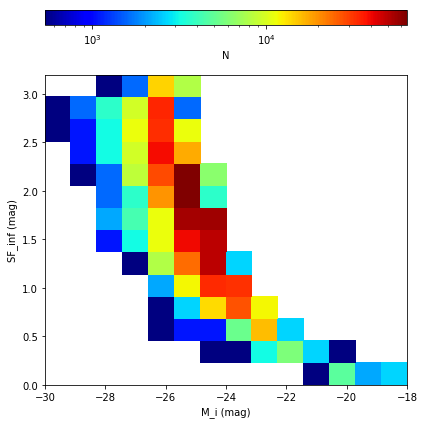

In [162]:
plotting_utils.plot_2d_hist(selected['M_i'].values,
                   selected['redshift'].values,
                   np.linspace(-30, -18, 15),
                   np.linspace(0.0, 3.2, 15),
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='M_i (mag)', 
                   y_label='SF_inf (mag)',
                   color_label='N',
                   cmap_name='jet',
                            weight=1.0/area)

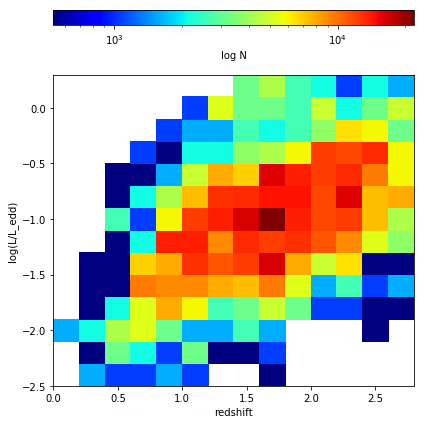

In [163]:
plotting_utils.plot_2d_hist(selected['redshift'].values,
                   selected['log_edd_ratio'].values,
                            np.arange(0.0, 3.0, 0.2),
                   np.arange(-2.5, 0.5, 0.2),
                  
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='redshift', 
                   y_label='log(L/L_edd)',
                   color_label='log N',
                   cmap_name='jet',
                            weight=1.0/area)

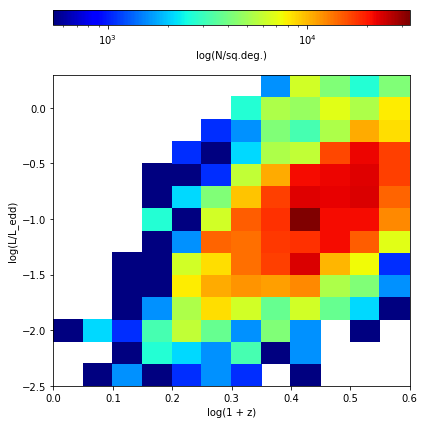

In [164]:

plotting_utils.plot_2d_hist(np.log10(1.0 + selected['redshift'].values),
                   selected['log_edd_ratio'].values,
                            np.arange(0.0, 0.62, 0.05),
                   np.arange(-2.5, 0.5, 0.2),
                  
                   invert_y_axis=False,
                   ticks_color=None,
                   invert_color=False,
                   log_color=True,
                   x_label='log(1 + z)', 
                   y_label='log(L/L_edd)',
                   color_label='log(N/sq.deg.)',
                   cmap_name='jet', 
                            weight=1.0/area)

## Likelihood of black hole mass

Text(0.5, 0, 'log(M_BH/M_sun)')

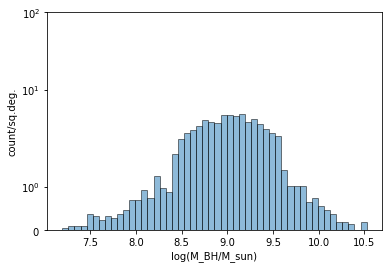

In [165]:
_, binning, _ = plt.hist(selected['log_BH_mass'].values,
                         weights=np.ones_like(selected['log_BH_mass'].values)/area,
                         bins=50, color='tab:blue', edgecolor='k', alpha=0.5)
plt.yscale('symlog')
plt.ylim([0, 100])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

Text(0.5, 0, 'log(M_BH/M_sun)')

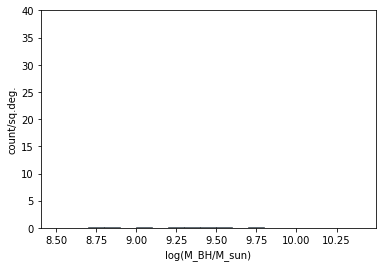

In [166]:
# Fig 16 top
_, binning, _ = plt.hist(selected[(selected['M_i'] > -28.5) & (selected['M_i'] < -27.5)]['log_BH_mass'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -28.5) & (selected['M_i'] < -27.5)]['log_BH_mass'].values)/area,
                         bins=np.arange(8.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 40])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

Text(0.5, 0, 'log(M_BH/M_sun)')

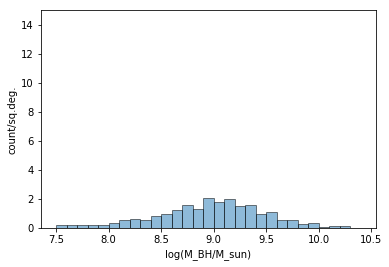

In [167]:
# Fig 16 second
_, binning, _ = plt.hist(selected[(selected['M_i'] > -26.5) & (selected['M_i'] < -25.5)]['log_BH_mass'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -26.5) & (selected['M_i'] < -25.5)]['log_BH_mass'].values)/area,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 15])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

Text(0.5, 0, 'log(M_BH/M_sun)')

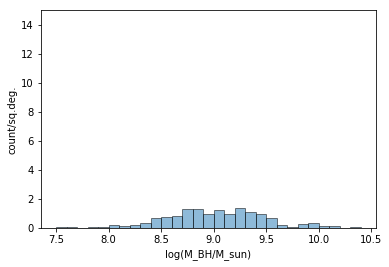

In [168]:
# Fig 16 third
_, binning, _ = plt.hist(selected[(selected['M_i'] > -24.5) & (selected['M_i'] < -23.5)]['log_BH_mass'].values,
                         weights=np.ones_like(selected[(selected['M_i'] > -24.5) & (selected['M_i'] < -23.5)]['log_BH_mass'].values)/area,
                         bins=np.arange(7.5, 10.5, 0.1), color='tab:blue', edgecolor='k', alpha=0.5, label='M_i=-28')
#plt.yscale('symlog')
plt.ylim([0, 15])
plt.ylabel('count/sq.deg.')
plt.xlabel('log(M_BH/M_sun)')

In [169]:
selected['fit_BH_mass'] = selected['log_BH_mass'] - 9.0
selected['fit_M_i'] = selected['M_i'] + 23.0
selected['fit_redshift'] = np.log10(1 + selected['redshift'].values)
selected['fit_wavelength'] = selected['log_rf_wavelength']

(array([ 472.,  867., 1180., 1495., 1802., 1521.,  813.,  355.,   91.,
          39.]),
 array([-0.66289358, -0.56208339, -0.46127319, -0.360463  , -0.25965281,
        -0.15884261, -0.05803242,  0.04277777,  0.14358797,  0.24439816,
         0.34520835]),
 <a list of 10 Patch objects>)

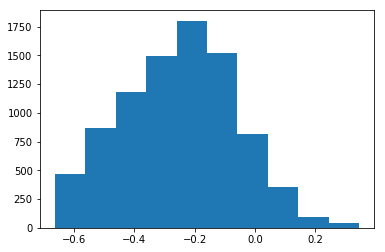

In [170]:
plt.hist(selected['fit_wavelength'])

(array([1.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 2.500e+01,
        3.600e+01, 6.400e+01, 1.380e+02, 2.120e+02, 3.180e+02, 4.830e+02,
        6.220e+02, 7.750e+02, 9.270e+02, 1.038e+03, 1.040e+03, 9.140e+02,
        6.610e+02, 5.170e+02, 3.740e+02, 2.200e+02, 1.200e+02, 7.700e+01,
        2.500e+01, 1.900e+01, 9.000e+00, 5.000e+00, 0.000e+00, 1.000e+00]),
 array([1.12319808, 1.19802817, 1.27285826, 1.34768835, 1.42251845,
        1.49734854, 1.57217863, 1.64700872, 1.72183882, 1.79666891,
        1.871499  , 1.94632909, 2.02115919, 2.09598928, 2.17081937,
        2.24564946, 2.32047956, 2.39530965, 2.47013974, 2.54496983,
        2.61979993, 2.69463002, 2.76946011, 2.8442902 , 2.9191203 ,
        2.99395039, 3.06878048, 3.14361057, 3.21844067, 3.29327076,
        3.36810085]),
 <a list of 30 Patch objects>)

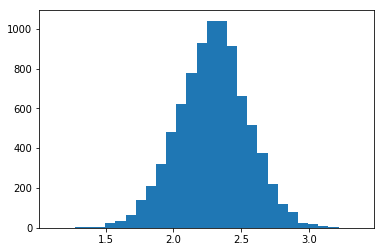

In [171]:
plt.hist(np.log10(selected['tau']), 30)

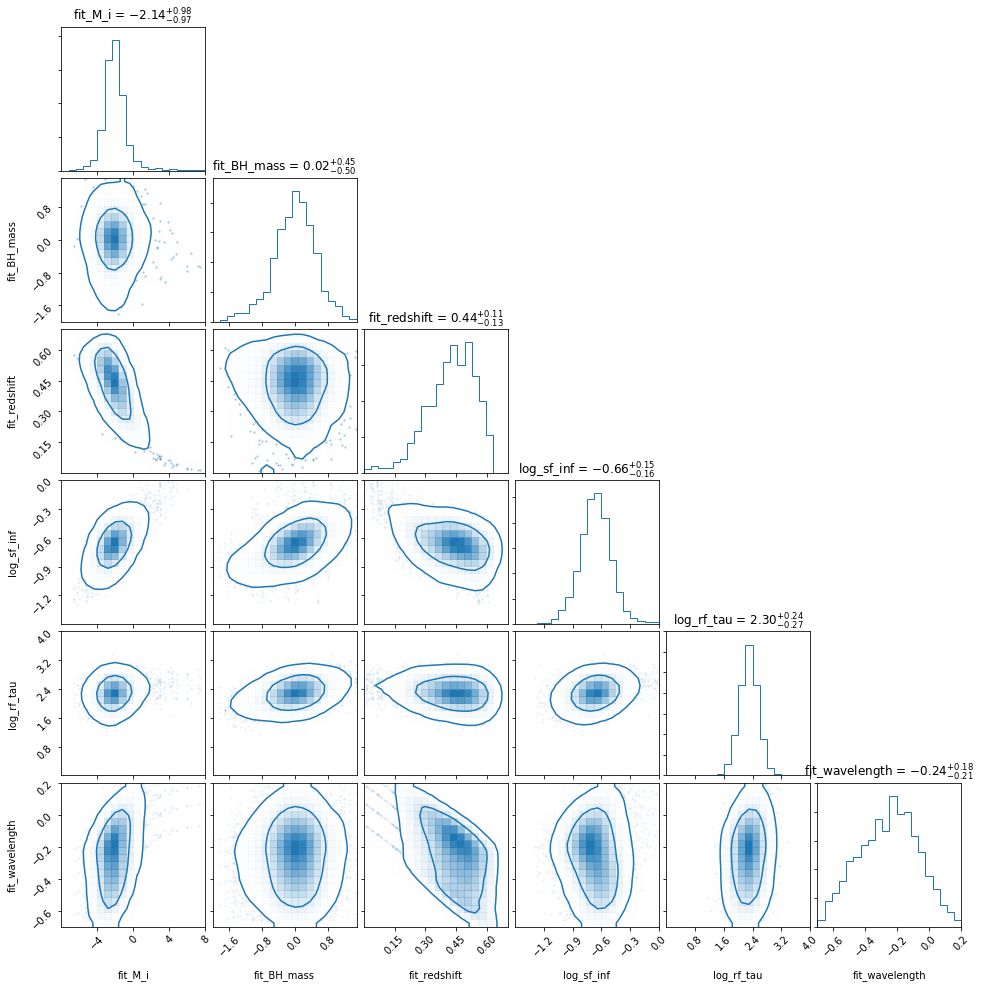

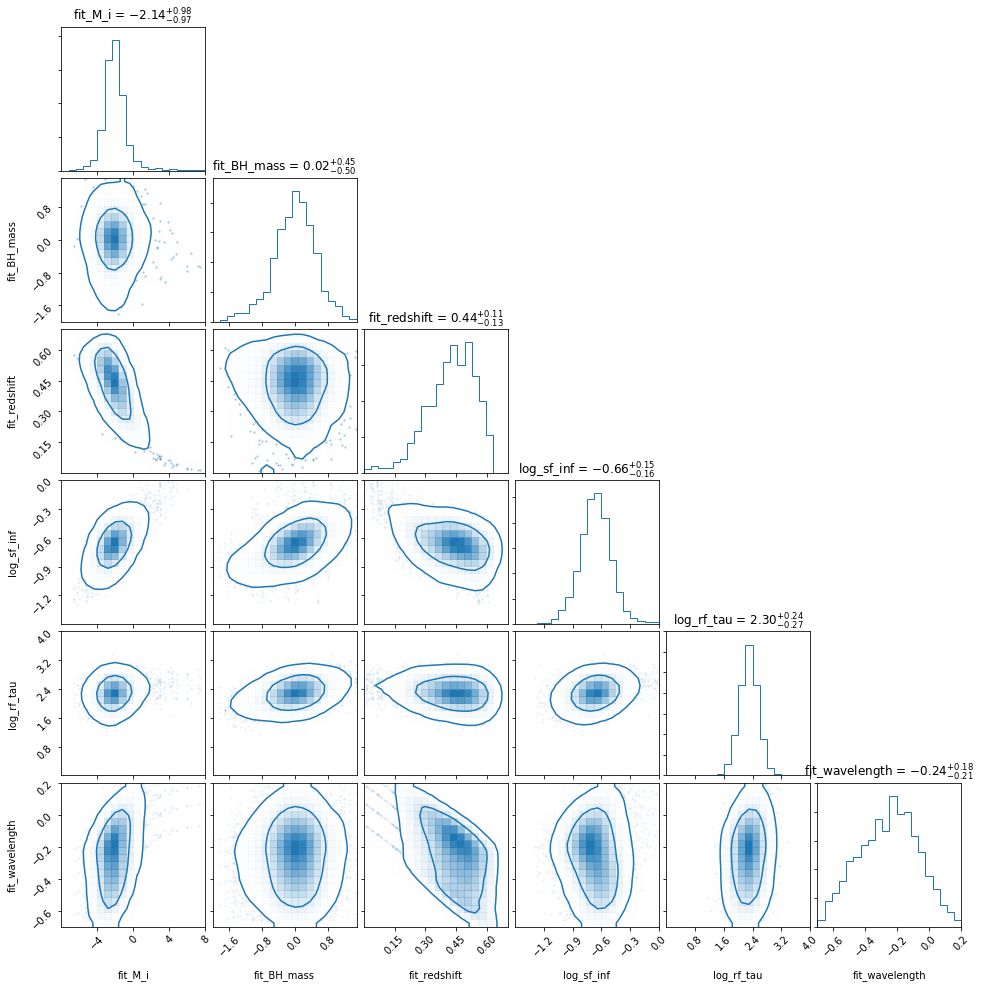

In [172]:
import corner

corner_cols = ['fit_M_i', 'fit_BH_mass', 'fit_redshift', 'log_sf_inf', 'log_rf_tau', 'fit_wavelength']
corner.corner(selected[corner_cols],
              color='tab:blue',
              smooth=1.0,
              labels=corner_cols,
              fill_contours=False,
              show_titles=True,
              levels=[0.68, 0.95],
              range=[[-8, 8], [-2.0, 1.5], [0, 0.7], [-1.5, 0], [0, 4], [-0.7, 0.2]],
              hist_kwargs=dict(density=True))

In [123]:
selected.columns

Index(['blackHoleMass', 'blackHoleAccretionRate', 'galaxy_id',
       'blackHoleEddingtonRatio', 'redshift', 'magNorm', 'seed', 'duty_cycle',
       'M_i', 'u', 'g', 'r', 'i', 'z', 'y', 'sf_inf', 'tau', 'bandpass',
       'log_rf_tau', 'log_sf_inf', 'log_BH_mass', 'rf_wavelength',
       'log_rf_wavelength', 'log_z_corr_inv', 'log_sf_inf_corrected',
       'log_rf_tau_corrected', 'log_edd_ratio'],
      dtype='object')